In [6]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

%matplotlib inline

# #Fock State

\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}

where $\gamma_n = \gamma_0(n+1)^{0.7}$ is the decoherence rate between levels $|n\rangle$ and $|n+1\rangle$

\begin{equation}
\Omega_{n,n+1} = \Omega_0\sqrt{n+1}\eta
\end{equation}
when $\eta\ll 1$
Here we use JCM to generate the data and use the formula above to fit it.
\begin{equation}
    H = \hbar \nu \hat{a}^\dagger \hat{a} + \frac{1}{2}\hbar\omega_0\sigma_z + \hbar\Omega(\sigma_+e^{i\eta(a+a^\dagger)}+h.c.)
\end{equation}
But in real:
\begin{equation}
\Omega_{n,n+s} = \Omega_{n+s,n} = \Omega_{0} e^{-\eta^2/2}\eta^{|s|}\sqrt{\frac{n_<!}{n_>!}}L^{|s|}_{n_<}(\eta^2)
\end{equation}
where $n_<$ ($n_>$ ) is the lesser (greater) of n+s and n
If s=1:
\begin{equation}
\Omega_{n,n+1} = \Omega_{n+1,n} = \Omega_{0} e^{-\eta^2/2}\eta L_{n}(\eta^2)/\sqrt{n+1}
\end{equation}

And:
\begin{equation}
    L_n^\alpha(X) = \sum_{m=0}^n(-1)^mC_{n+\alpha}^{n-m}\frac{X^m}{m!}
\end{equation}
Thus $\Omega_{n+1,n}/\Omega_{0,1} = L^1_{n}(\eta^2)/\sqrt{n+1}$

In [7]:
from scipy.special import genlaguerre

Text(0, 0.5, '$\\Omega_{n,n+1}/\\Omega_{0,1}$')

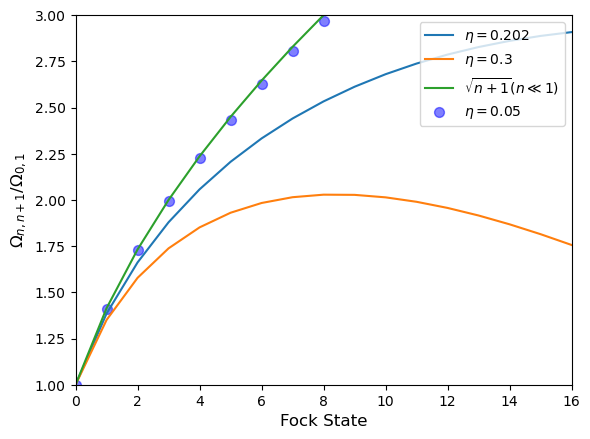

In [8]:
Fock_state = np.array(range(0,20))
def genlaguerre_function(eta,nlist,s):
    function_value = []
    for n in nlist:
        function_value.append(genlaguerre(n,s)(eta**2))
    return np.array(function_value)
function_value01 = genlaguerre_function(0.202,Fock_state,1)
function_value02 = genlaguerre_function(0.3,Fock_state,1)
function_value03 = genlaguerre_function(0.05,Fock_state,1)
plt.plot(Fock_state,function_value01/np.sqrt(Fock_state+1),label=r"$\eta=0.202$")
plt.plot(Fock_state,function_value02/np.sqrt(Fock_state+1),label=r"$\eta=0.3$")
plt.plot(Fock_state,np.sqrt(Fock_state+1),label=r"$\sqrt{n+1}(n\ll 1)$")
plt.scatter(Fock_state,function_value03/np.sqrt(Fock_state+1),label=r"$\eta=0.05$",s=50,alpha=0.5,c="blue")
plt.legend(loc=1)
plt.ylim(1,3)
plt.xlim(0,16)
plt.xlabel("Fock State",fontsize=12)
plt.ylabel(r"$\Omega_{n,n+1}/\Omega_{0,1}$",fontsize=12)

# State Preparation

In [9]:
def generate_thermal_state(N,nbar):
    if nbar == 0:
        return fock(N, 0)
    else:
        coeff = 1/(1+nbar)
        thermal_state =  fock(N, 0)/(1+nbar)
        for ith in range(1,N):
            thermal_state+=fock(N,ith)*(nbar/(1+nbar))**ith/(1+nbar)
            coeff += (nbar/(1+nbar))**ith/(1+nbar)
    return thermal_state/coeff

Similarly, the average photon number in a coherent state is
\begin{equation}
\langle n\rangle = \langle\hat{a}^\dagger a\rangle = |\alpha|^2 
\end{equation}

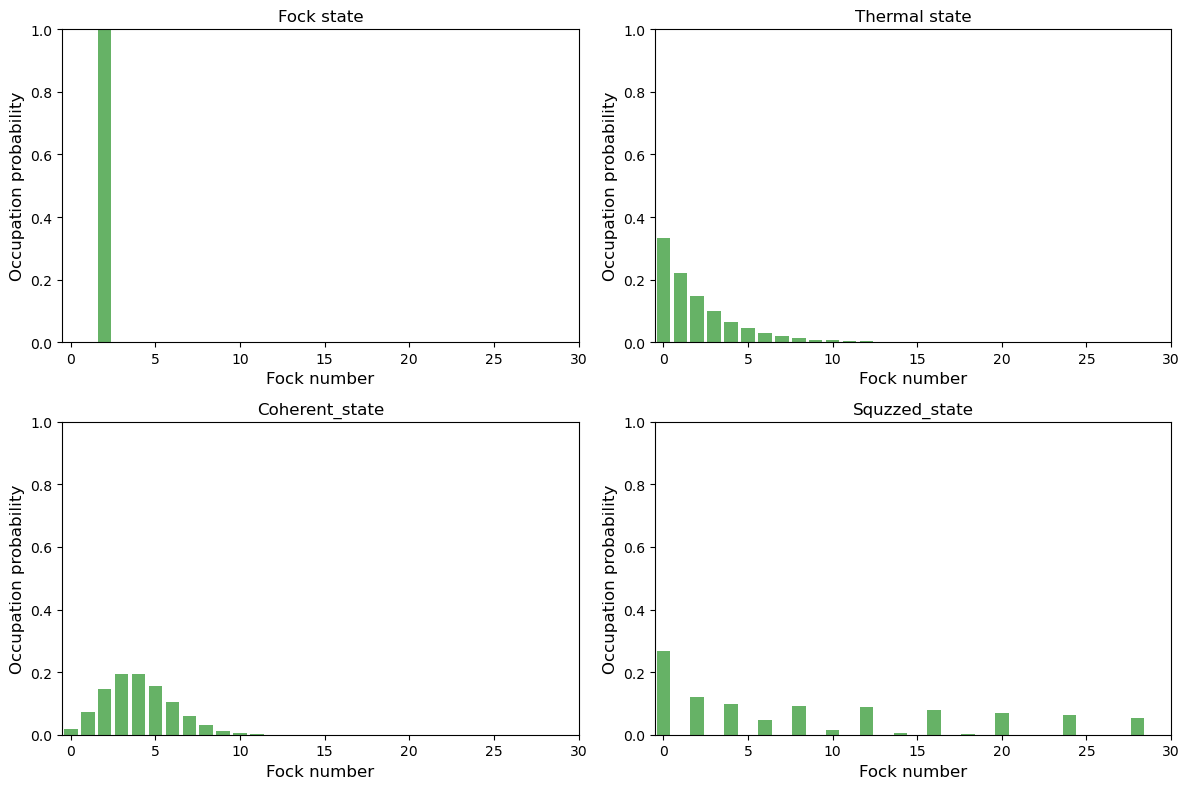

In [10]:
N = 30

fock_state = fock(N, 2)
n_th=2
rho_thermal = thermal_dm(N,n_th)
coherent_state = coherent(N, 2)
squeezed_state  = squeeze(N,2)*basis(N,0)


fig, axes = plt.subplots(2, 2, figsize=(12,8))

plot_fock_distribution(fock_state, fig=fig, ax=axes[0,0], title="Fock state");

plot_fock_distribution(rho_thermal, fig=fig, ax=axes[0,1], title="Thermal state");

plot_fock_distribution(coherent_state, fig=fig, ax=axes[1,0], title="Coherent_state");

plot_fock_distribution(squeezed_state, fig=fig, ax=axes[1,1], title="Squzzed_state");

fig.tight_layout()

plt.show()

In [11]:
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
rabi_amp = 0.5*np.pi*2




a = tensor(destroy(N), qeye(2))
sp = tensor(qeye(N),destroy(2))
sm = tensor(qeye(N),create(2))
sz = tensor(qeye(N), sigmaz())
tlist = np.linspace(0, 40, 200)

In [12]:
def Ham(eta,under_lamb_dicke=False,use_rwa=False):
    H0 = wc * a.dag() * a + wa / 2 *sz
    if under_lamb_dicke==True:
        #In lamb dicke regime(eta \ll 1)
        if use_rwa==True:
            #Under RWA
            H1 = rabi_amp*eta*(a.dag()*sm+a*sp)
        else:
            H1 = rabi_amp*eta*(a.dag() + a )*(sm+sp)
        return H0+H1
    else:
        def H1_coeff(t,args):
            return g*(((1j*(eta*(a.dag() + a)+wL*t)).expm())+((-1j*(eta*(a.dag() + a)+wL*t)).expm()))
        return [H0,[H1_coeff,(sm+sp)]]

# Fock State

In [13]:
# intial state
psi0 = tensor(fock_state, basis(2, 0))
eta = 0.202
output_use_rwa = mesolve(Ham(eta,under_lamb_dicke=True,use_rwa=True), psi0, tlist,e_ops=[a.dag() * a, sm.dag() * sm])

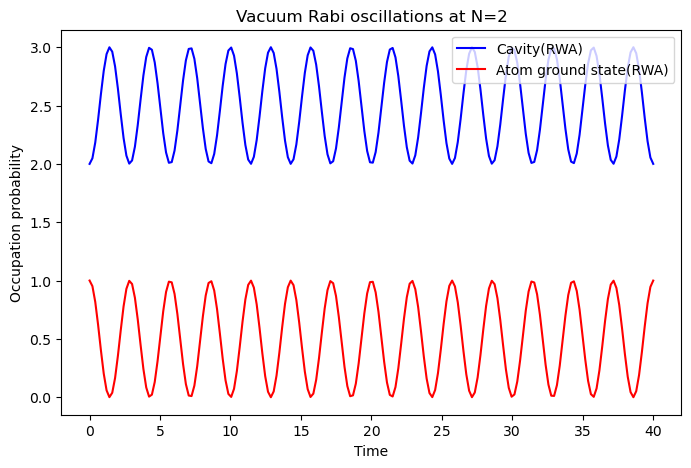

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tlist, output_use_rwa.expect[0], label="Cavity(RWA)",c="blue")
ax.plot(tlist, output_use_rwa.expect[1], label="Atom ground state(RWA)",c="red")

ax.legend(loc=1)
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Vacuum Rabi oscillations at N={}".format(n_th));

we use eq:\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}
to fit it

Fit Fock State Number= 2


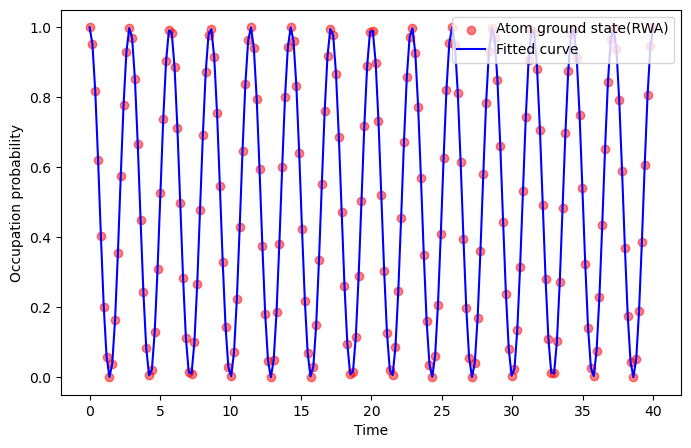

In [15]:
from scipy.optimize import leastsq
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(tlist, output_use_rwa.expect[1], label="Atom ground state(RWA)",c="red",alpha=0.5)
def Population(param,t):                        # 定义拟合函数形式
    n = param
    return np.cos(rabi_amp*np.sqrt(n+1)*eta*t)**2
def error (param,x,y):                   # 拟合残差
    return Population(param,x)-y
p0 = 2
param =leastsq(error, p0, args=(tlist,output_use_rwa.expect[1]))
y_fitted = Population(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1)
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
print("Fit Fock State Number=",int(param[0]))

# Thermal State

\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \sum_{n=0}^{\infty}P_n\cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}
热态下有:
where $P_n= (\frac{\bar{n}}{\bar{n}+1})^n(\frac{1}{\bar{n}+1})$


\begin{equation}
    \rho = \frac{\exp(-H/k_BT)}{\text{Tr}(\exp(-H/k_BT))}
\end{equation}


此时哈密顿量可以利用产生湮灭算符表示:

\begin{equation}
    H = \hbar w(a^\dagger a+\frac{1}{2})
\end{equation}

而$\rho = \sum_n p _n |{n}\rangle\langle{n}|$

故

\begin{equation}
    p_n = \langle{n}|\rho|{n}\rangle = \frac{\langle{n}|\exp(-H/k_BT)|{n}\rangle}{\text{Tr}(\exp(-H/k_BT))}
\end{equation}

其中

\begin{equation}
    \text{Tr} (\exp(-H/k_BT)) =  \sum_{n}\langle{n}|\exp(-H/k_BT)|{n}\rangle = \sum_n(\exp(-\hbar wn/k_BT))\exp(-\frac{1}{2k_BT})
\end{equation}


等比数量求和得到:

\begin{equation}
    \sum_n(\exp(-\hbar wn/k_BT))\exp(-\frac{1}{2k_BT}) = \exp(-\frac{1}{2k_BT}) \frac{1}{1-\exp(-\hbar w /k_BT)}
\end{equation}

而

\begin{equation}
    \langle{n}|\exp(-H/k_BT)|{n}\rangle = \exp(-n\hbar w/k_BT)\exp(-\frac{1}{2k_BT})
\end{equation}


故:

\begin{equation}
    p_n =(1-\exp(-\hbar w /k_BT))\exp(-n\hbar w/k_BT)
\end{equation}

故:

\begin{equation}
    \rho = \sum_n p _n |{n}\rangle\langle{n}|=(1-\exp(-\hbar w /k_BT)) \sum_n \exp(-n\hbar w/k_BT) |{n}\rangle\langle{n}|
\end{equation}


故对于平均声子数的均值为:
\begin{equation}
    \langle n \rangle = \text{Tr}(\hat{N}\rho) = \text{Tr}(\hat{a}^\dagger \hat{a}\rho)
\end{equation}

求迹:

\begin{equation}
    \sum_k\langle{k}|\hat{a}^\dagger \hat{a}\rho|{k}\rangle =(1-\exp(-\hbar w /k_BT))\sum_k\langle{n}|\sum_n n\exp(-n\hbar w/k_BT) |{n}\rangle\langle{n}|{k}\rangle
\end{equation}

故上式为:

\begin{equation}
    (1-\exp(-\hbar w /k_BT))\sum_k k\exp(-k\hbar w/k_B T)
\end{equation}

后面一项利用错位相减法可以得到:

\begin{equation}
    \sum_k k\exp(-k\hbar w/k_B T) = \exp(-\hbar w/k_BT)/(1-\exp(-\hbar w/k_BT))^2
\end{equation}

故:

\begin{equation}
    \langle n \rangle =\exp(-\hbar w/k_BT)/(1-\exp(-\hbar w/k_BT)) = (\exp(\hbar w/k_BT)-1)^{-1}
\end{equation}


回代到密度矩阵中:

\begin{equation}
    \rho  = \sum_{n}(\frac{\langle n \rangle^n}{(\langle n \rangle+1)^{n+1}})|{n}\rangle\langle{n}|
\end{equation}

故
\begin{equation}
    \rho_{n,n} = p_n = (\frac{\bar{n}}{\bar{n}+1})^n\frac{1}{\bar{n}+1}
\end{equation}

In [16]:
dm0 = tensor(rho_thermal, ket2dm(basis(2, 0)))

eta = 0.202
tlist = np.linspace(0, 50, 500)
output_use_rwa = mesolve(Ham(eta,under_lamb_dicke=True,use_rwa=True), dm0, tlist,e_ops=[a.dag() * a, sm.dag() * sm])

Thermal State Average Fock Number 1.9999339397029348


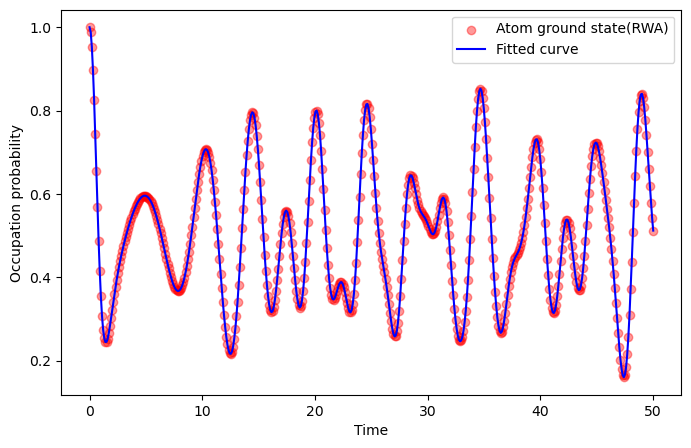

In [17]:
from scipy.optimize import leastsq
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(tlist, output_use_rwa.expect[1], label="Atom ground state(RWA)",c="red",alpha=0.4)
def tsp(param,t):                        # 定义拟合函数形式
    nbar = param
    p = 0
    for i in range(N):
        pn = (nbar/(nbar+1))**(i)/(nbar+1)
        p+= pn*np.cos(rabi_amp*np.sqrt(i+1)*eta*t)**2
    return p
def tsp_error (param,x,y):                   # 拟合残差
    return tsp(param,x)-y
p0 = 1
param =leastsq(tsp_error, p0, args=(tlist,output_use_rwa.expect[1]))
y_fitted = tsp(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1)
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
print("Thermal State Average Fock Number",float(param[0]))

# Coherent state
\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \sum_{n=0}^{\infty}P_n\cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}
where $P_n=(\bar{n}^ne^{-\bar{n}})/n!$

In [18]:
psi0 = tensor(coherent_state, basis(2, 0))
eta = 0.202
tlist = np.linspace(0, 20, 500)
output_use_rwa = mesolve(Ham(eta,under_lamb_dicke=True,use_rwa=True), psi0, tlist,e_ops=[a.dag() * a, sm.dag() * sm])

Coherent State Average Fock Number 3.9998371819660177


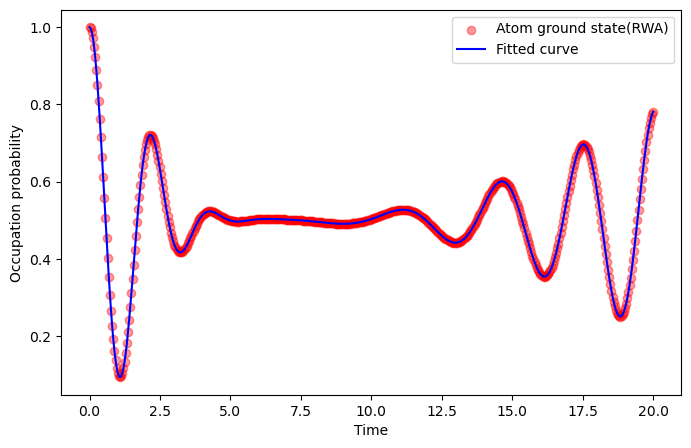

In [19]:
from scipy.optimize import leastsq
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(tlist, output_use_rwa.expect[1], label="Atom ground state(RWA)",c="red",alpha=0.4)
def csp(param,t):                        # 定义拟合函数形式
    nbar = param
    p = 0
    for i in range(N):
        pn = float((nbar**i)*np.exp(-nbar)/np.math.factorial(i))
        p+= pn*np.cos(rabi_amp*np.sqrt(i+1)*eta*t)**2
    return p
def csp_error (param,x,y):                   # 拟合残差
    return csp(param,x)-y
p0 = 4
param =leastsq(csp_error, p0, args=(tlist,output_use_rwa.expect[1]))
y_fitted = csp(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1)
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
print("Coherent State Average Fock Number",float(param[0]))

# Squeezed State

\begin{equation}
S(\xi) = \exp(\frac{1}{2}(\xi (\hat{a}^\dagger)^2-\xi^*a^2));\xi=re^{i\theta}
\end{equation}
And
\begin{equation}
S(\xi)|{0} \rangle= \exp(-\frac{1}{4}|\xi|^2)\sum_n\frac{\xi^n}{n!2^n}\sqrt{(2n)!}|2n\rangle
\end{equation}
And express in r:
\begin{equation}
|0,r\rangle = \frac{1}{\sqrt{cosh(r)}}\sum_n\frac{\sqrt{(2n)!}}{2^nn!}tanh (r^n)|2n\rangle
\end{equation}
The population distribution for a vacuum squeezed state is relatively flat and is restricted to the even states,
\begin{equation}
P_{2n} = N(2n)!(tanh(r^{2n}))/(2^nn!)^2,\text{ with }\beta= \exp(2r)
\end{equation}
https://physics.stackexchange.com/questions/425290/derive-explicit-expression-of-squeezed-vacuum-state-in-the-fock-basis

In [42]:
r = 1.2
beta = np.exp(2*r)
squeezed_state  = squeeze(N,r)*basis(N,0)
psi0 = tensor(squeezed_state, basis(2, 0))

eta = 0.202
tlist = np.linspace(0, 20, 500)
output_use_rwa = mesolve(Ham(eta,under_lamb_dicke=True,use_rwa=True),psi0, tlist,e_ops=[a.dag() * a, sm.dag() * sm])

Squeezed State Param 1.2010668364121988


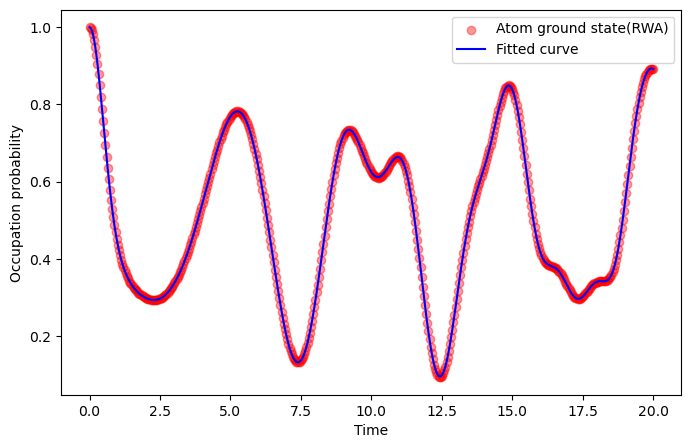

In [43]:
from scipy.optimize import leastsq
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(tlist, output_use_rwa.expect[1], label="Atom ground state(RWA)",c="red",alpha=0.4)
def sqp(param,t):                        # 定义拟合函数形式
    r = param
    p = 0
    coeff = 0
    for i in range(0,N,2):
        ith = i//2
        pn = float(np.math.factorial(i)*np.tanh(r)**i/(2**ith*np.math.factorial(ith))**2)
#       pn =xi**i/(np.math.factorial(ith)*2**ith)**2*np.math.factorial(i)
        p+= pn*np.cos(rabi_amp*np.sqrt(i+1)*eta*t)**2
        coeff+=pn
    return p/coeff
def sqp_error (param,x,y):                   # 拟合残差
    return sqp(param,x)-y
p0 = 2
param =leastsq(sqp_error, p0, args=(tlist,np.real(output_use_rwa.expect[1])))
y_fitted = sqp(param[0],tlist)
ax.plot(tlist,y_fitted,'-b', label ='Fitted curve')
ax.legend(loc=1)
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
print("Squeezed State Param",np.abs(float(param[0])))